In [7]:
#%pip install biopython
#%pip install scikit-learn
#%pip install pandas
#%pip install numpy
#%pip install torch
#%pip install torchmetrics
%pip install lightning

     ---------------------------------------- 0.0/56.8 kB ? eta -:--:--
     ---------------------------------------- 56.8/56.8 kB 2.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.1 MB 14.2 MB/s eta 0:00:01
   ---------------------------- ----------- 1.5/2.1 MB 18.5 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 16.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [47]:
import os 
import numpy as np
import pandas as pd
import scipy
import sklearn.metrics as skmetrics

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import lightning as L

import torchmetrics
from torchmetrics.regression import PearsonCorrCoef

In [ ]:
dataset_train.df

In [49]:
from Bio.PDB import PDBList, PDBParser, MMCIFParser
#PDBList().get_all_entries()

def downloadStructure(name):
    pdb_id = name

    #check if file is available


    pdb_file = PDBList().retrieve_pdb_file(pdb_id, file_format='mmCif', pdir="structures")
    
    if not os.path.exists(pdb_file):
        return None
    
    return MMCIFParser().get_structure(pdb_id, pdb_file)


In [50]:
from Bio.PDB import NeighborSearch
from Bio.Data.IUPACData import protein_letters_3to1

def removeHeteroatoms(structure):
    model = structure[0]
    chains = model.get_chains()
    chain = next(iter(chains))
    residues = chain.get_residues()
    #print(next(iter(residues)))

    #remove all heteroatoms from chain
    heteroatoms = []
    for residue in chain:
        if(residue.id[0] != ' '):
            #remove residue from chain
            heteroatoms.append(residue.id)

    for heteroatom in heteroatoms:
        chain.detach_child(heteroatom)

    names = []
    #print all residues
    for residue in chain:
        names.append(residue.get_resname())

    string = ''.join([protein_letters_3to1[aa.get_resname()[0]+aa.get_resname()[1:].lower()] for aa in chain])

    return chain, string


In [51]:
#next(iter(next(iter(downloadStructure("1F0M")[0].get_chains())).get_residues()))

In [52]:
dataset_train.df["wt_seq"][0][0]

'SPEVQIAILTEQINNLNEHLRVHKKDHHSRRGLLKMVGKRRRLLAYLRNKDVARYREIVEKLG'

In [53]:
import numpy as np
from Bio.Data.IUPACData import protein_letters_3to1

def getNClosestAAs(chain, index, nClosestAAs = 10, maxRadius = 20.0):
    #distance matix
    # Create a list of all atoms in the structure
    atoms = [atom for atom in chain.get_atoms()]
    
    # Create a NeighborSearch object
    ns = NeighborSearch(atoms)

    #print(next(iter(chain)))
    #print("get residue at index", index)
    try:
        residue = chain[index+1] #because numbering starts at 1
    except:
        return None
    #print(residue)

    # Calculate the distance between the residues
    neighbors = ns.search(residue["CA"].coord, level="R", radius=maxRadius)
    distances = [(protein_letters_3to1[aa.get_resname()[0]+aa.get_resname()[1:].lower()], residue["CA"]-aa["CA"]) for aa in neighbors]
    #sort by distance
    distances.sort(key=lambda x: x[1])
    # Ensure distance is always nClosestAAs large, if too short, fill with 0
    if len(distances) < nClosestAAs:
        distances.extend([("0", 0)] * (nClosestAAs - len(distances)))
    else:
        distances = distances[:nClosestAAs]

    return distances




In [54]:
aa_alphabet = 'ACDEFGHIKLMNPQRSTVWY' # amino acid alphabet
aa_to_int = {aa: i for i, aa in enumerate(aa_alphabet)} # mapping from amino acid to number

def one_hot_encode(sequence):
    # initialize a zero matrix of shape (len(sequence), len(amino_acids))
    one_hot = torch.zeros(len(sequence), len(aa_alphabet))
    if sequence != "0":
        for i, aa in enumerate(sequence):
            # set the column corresponding to the amino acid to 1
            one_hot[i].scatter_(0, torch.tensor([aa_to_int[aa]]), 1)
    return one_hot

In [217]:
next(iter(downloadStructure("1UFM")[0]["A"].get_residues()))

Structure exists: 'structures/1ufm.cif' 


<Residue GLY het=  resseq=289 icode= >

In [55]:
dataset_train.df["mut_type"][0][19*0+0]
#dataset_train.df["mut_type"][0][1194], dataset_train.df["mut_type"][0][-1]


'S1Q'

In [219]:
def getTensorFromProteinOLD(proteinName, wt_seq, mut_types, nClosestAAs = 5):

    print("Getting " + proteinName + " tensor: " + wt_seq + " " + mut_types[0] + " " + mut_types[-1])
    ###for each protein
    structure = downloadStructure(proteinName[:4])
    if structure == None:
        return None
    chain, string = removeHeteroatoms(structure)

    print("Structure sequence: " + string)
    #wt_seq = dataset_train.df["wt_seq"][0][proteinIndex]

    matching = (string.find(wt_seq),string.find(wt_seq)+len(wt_seq))
    print(matching)

    matchingSeq_len = len(wt_seq) # = matching[1]-matching[0]

    print(len(chain))

    

    #len(wt_seq), len(aa_alphabet)
    
    # Iterate over each residue in the chain
    #for index, residue in enumerate(chain):

    #len of matching sequence, max amount of mutations at the position, amount of closest AAs, one hot encoding of amino acid 
    aaDistances = torch.zeros((matchingSeq_len, len(aa_alphabet), nClosestAAs, len(aa_alphabet)))

    for residueIndex in range(1, matchingSeq_len):
        
        distances = getNClosestAAs(chain, matching[0]+residueIndex, nClosestAAs = nClosestAAs)
        if distances == None:
            return None
        #change wt residue to mutation
        
        mut_toThatHaveData = [mut_type[-1] for mut_type in mut_types if str(residueIndex+matching[0]) in mut_type]
        for mutationIndex in range(len(aa_alphabet)): #20 because 20 amino acids thought -1 because wt is already in the list but wt is different every time
               ###for each mutation
               #print(residueIndex*(len(aa_alphabet)-1)+mutationIndex)
            
            #check if mutation is at this position exists
            mut_to = aa_alphabet[mutationIndex]

            if(mut_toThatHaveData.__contains__(mut_to)):
                #print("Mutation at position " + str(residueIndex) + " to " + mut_to + " in " + proteinName)
                #mut_type = mut_types[residueIndex*(len(aa_alphabet)-1)+mutationIndex]
                #mutation_pos = mut_type[1:-1]
               #print("mut_type:" + str(mut_type))
               #print("mutation_pos:" + str(mutation_pos))
               #print(mut_type)
                distances[0] = (mut_to, 0.0) #mutated AA, distance to itself is 0
                aaDistances[residueIndex][mutationIndex][0] = one_hot_encode(distances[0][0])*-1

                for idx, aa in enumerate(distances[1:], start=1):
                    # Rest of the code
                #print(aa[0],aa[1])
                #print(proteinIndex,residueIndex,mutationIndex,idx)
                    aaDistances[residueIndex][mutationIndex][idx] = one_hot_encode(aa[0])*aa[1]
               #for idx, distance in enumerate(distances):
            else:
                aaDistances[residueIndex][mutationIndex] = torch.zeros((nClosestAAs, len(aa_alphabet)))
                #print("No data for mutation at position " + str(residueIndex) + " to " + mut_to + " in " + proteinName)
                   
       #aaDistances[residueIndex] = [np.append(one_hot_encode(aa[0]),aa[1]) for aa in distances]
       
   #print(distances, len(distances))
    return aaDistances

    #aaDistances = torch.empty(0)
    aaDistances = []
    distances = []
    oldMutationPos = -1

    for mutation in mut_types:
        mutation_pos = int(mutation[1:-1])
        mutatedFrom = mutation[0]
        mutatedTo = mutation[-1]
        print(mutation_pos)
        
        if(mutation_pos != oldMutationPos):
            distances = getNClosestAAs(chain, matching[0]+mutation_pos, nClosestAAs = nClosestAAs)
        
        oldMutationPos = mutation_pos

        distances[0] = (mutatedTo, 0.0) #mutated AA, distance to itself is 0

        #print(one_hot_encode(distances[0][0]))
        aaDistances.append(one_hot_encode(distances[0][0])*-1)
#        aaDistances = torch.cat((aaDistances,one_hot_encode(distances[0][0])*-1))
        #print(torch.flatten(torch.stack([one_hot_encode(aa[0])*aa[1] for aa in distances[1:]])))
        [aaDistances.append(one_hot_encode(aa[0])*aa[1]) for aa in distances[1:]]
#        aaDistances = torch.cat((aaDistances,torch.flatten(torch.stack([one_hot_encode(aa[0])*aa[1] for aa in distances[1:]]))))
        #aaDistances.append(np.append(one_hot_encode(aa[0]),aa[1]) for aa in distances)

    return aaDistances

In [290]:
def getTensorFromProtein(proteinName, wt_seq, mut_types, nClosestAAs = 5):

    print("Getting " + proteinName + " tensor: " + wt_seq + " " + mut_types[0] + " " + mut_types[-1])
    ###for each protein
    structure = downloadStructure(proteinName[:4])
    if structure == None:
        return None
    chain, string = removeHeteroatoms(structure)

    print("Structure sequence: " + string)
    #wt_seq = dataset_train.df["wt_seq"][0][proteinIndex]

    matching = (string.find(wt_seq),string.find(wt_seq)+len(wt_seq))
    print(matching)

    matchingSeq_len = len(wt_seq) # = matching[1]-matching[0]

    print(len(chain))

    

    #len(wt_seq), len(aa_alphabet)
    
    # Iterate over each residue in the chain
    #for index, residue in enumerate(chain):

    #len of matching sequence, max amount of mutations at the position, amount of closest AAs, one hot encoding of amino acid 
    aaDistances = torch.zeros((matchingSeq_len, nClosestAAs + len(aa_alphabet), len(aa_alphabet)))

    #aaDistances = torch.zeros((matchingSeq_len, nClosestAAs-1, len(aa_alphabet)))

    for residueIndex in range(matchingSeq_len):
        
        distances = getNClosestAAs(chain, matching[0]+residueIndex, nClosestAAs = nClosestAAs)
        if distances == None:
            return None
        #change wt residue to mutation
        
        mut_toThatHaveData = [mut_type[-1] for mut_type in mut_types if str(residueIndex+matching[0]) in mut_type]
        
        
        for mutationIndex in range(len(aa_alphabet)): #20 because 20 amino acids thought -1 because wt is already in the list but wt is different every time
               ###for each mutation
               #print(residueIndex*(len(aa_alphabet)-1)+mutationIndex)
            
            #check if mutation is at this position exists
            mut_to = aa_alphabet[mutationIndex]

            if(mut_toThatHaveData.__contains__(mut_to)):
                #print("Mutation at position " + str(residueIndex) + " to " + mut_to + " in " + proteinName)
                #mut_type = mut_types[residueIndex*(len(aa_alphabet)-1)+mutationIndex]
                #mutation_pos = mut_type[1:-1]
               #print("mut_type:" + str(mut_type))
               #print("mutation_pos:" + str(mutation_pos))
               #print(mut_type)
                distances[0] = (mut_to, 0.0) #mutated AA, distance to itself is 0
                aaDistances[residueIndex][mutationIndex] = one_hot_encode(mut_to)

                
            else:
                aaDistances[residueIndex][mutationIndex] = torch.zeros((len(aa_alphabet)))
                #print("No data for mutation at position " + str(residueIndex) + " to " + mut_to + " in " + proteinName)
        
        for idx, aa in enumerate(distances[1:]):
             
            aaDistances[residueIndex][len(aa_alphabet)+idx] = one_hot_encode(aa[0])*aa[1]
             
            #aaDistances[residueIndex][idx] = one_hot_encode(aa[0])*aa[1]
               #for idx, distance in enumerate(distances):          
       #aaDistances[residueIndex] = [np.append(one_hot_encode(aa[0]),aa[1]) for aa in distances]
       
   #print(distances, len(distances))
    return aaDistances

In [291]:
wt_name = dataset_train.wt_names[1]
# get the correct row
mut_row = dataset_train.df.loc[wt_name]
print("mut_type_len =", len(mut_row["mut_type"]))
getTensorFromProtein(wt_name, mut_row["wt_seq"][0], mut_row["mut_type"])[0]

mut_type_len = 1287
Getting 1AOY.pdb tensor: QEELVKAFKALLKEEKFSSQGEIVAALQEQGFDNINQSKVSRMLTKFGAVRTRNAKMEMVYCLPAELGV Q1E V69C
Structure exists: 'structures/1aoy.cif' 
Structure sequence: MRSSAKQEELVKAFKALLKEEKFSSQGEIVAALQEQGFDNINQSKVSRMLTKFGAVRTRNAKMEMVYCLPAELGVPTT
(6, 75)
78


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0

In [292]:
#ignoreList = []

In [293]:
(ignoreList)

['1F0M',
 '1GL5',
 '1H8K',
 '1I2T',
 '1IFY',
 '1K1V',
 '1LP1',
 '1ORC',
 '1QKX',
 '1SRM',
 '1TUD',
 '1UFM',
 '1URF',
 '1VII',
 '1W4F',
 '1W4G',
 '1Y0M',
 '1YRF',
 '1YU5',
 '1ZLM',
 '2BTT',
 '2CDT',
 '2CJJ',
 '2EXD',
 '2GP8',
 '2JVG',
 '2K2A',
 '2KFV',
 '2LCL',
 '2LHR',
 '2LVN',
 '2M2J',
 '2MA4',
 '2MCH',
 '2MCK',
 '2MKY',
 '2MW9',
 '2MWA',
 '2MWB',
 '2MXD',
 '2MYX',
 '2N4R',
 '2N88',
 '2O2W',
 '2QFF',
 '2RJV',
 '3I35',
 '3L1X',
 '3MYC',
 '4G3O',
 '4HCK',
 '5JRT',
 '5OAO',
 '5UYO',
 '5VNT',
 '5Z2S',
 '6NMW',
 '7JJK',
 'EEHE',
 'EHEE',
 'HEEH',
 'HHH_',
 'r10_',
 'r11_',
 'r16_',
 'r4_4',
 'r6_5',
 'r6_8',
 'r7_5',
 'v2K4',
 'v2_2',
 'v2_4',
 'v2_6',
 '1WCL',
 '2K9D',
 '2RU9',
 '2WNM',
 '3ZGK',
 '5LXJ',
 'r15_',
 'r3_1',
 '1GYZ',
 '1QKH',
 '1QP2',
 '1TUC',
 '1W4H',
 '2BTH',
 '2KWH',
 '2WXC',
 '3DKM',
 '4C26',
 'r12_',
 'r18_',
 '1E6H',
 '1OPS']

In [294]:
# sequence data, comes already batched, so treat accordingly in dataloader (batch_size=1)
class SequenceData(Dataset):
    def __init__(self, csv_file, label_col="ddG_ML"):
        """
        Initializes the dataset. 
        input:
            csv_file: path to the relevant data file, eg. "/home/data/mega_train.csv"
        """
        
        self.min_size = 72
        self.seqTensors = {}
        
        self.df = pd.read_csv(csv_file, sep=",")
        self.label_col = label_col
        # only have mutation rows
        self.df = self.df[self.df.mut_type!="wt"]
        # process the mutation row
        self.df["mutation_pos"] = self.df["mut_type"].apply(lambda x: int(x[1:-1])-1) # make position start at zero
        self.df["mutation_to"] = self.df["mut_type"].apply(lambda x: aa_to_int[x[-1]]) # give numerical label to mutation

        # group by wild type
        self.df = self.df.groupby("WT_name").agg(list)
        # get wild type names
        self.wt_names = self.df.index.values
        # precompute one-hot encoding for faster training
        self.encoded_seqs = {}
        for wt_name in self.wt_names:
            # get the correct row
            
            #download structure
            print(wt_name[:4])
            if not ignoreList.__contains__(wt_name[:4]):
                structure = downloadStructure(wt_name[:4])

                if structure is None:
                    print("No structure found for " + wt_name)
                    ignoreList.append(wt_name[:4])
                    #remove from df
                    self.df = self.df.drop(wt_name)
                    continue
            
                mut_row = self.df.loc[wt_name]
                tensorFromProtein = getTensorFromProtein(wt_name, mut_row["wt_seq"][0], mut_row["mut_type"], nClosestAAs=10)
                if tensorFromProtein == None:
                    ignoreList.append(wt_name[:4])
                    continue
            
                self.seqTensors[wt_name] = tensorFromProtein
            #seq = mut_row["wt_seq"][0]
            #self.encoded_seqs[wt_name] = one_hot_encode(seq)
            #for i in range(self.min_size-len(self.encoded_seqs[wt_name])):
            #    #print(wt_name, i)
            #    self.encoded_seqs[wt_name] = torch.cat((self.encoded_seqs[wt_name], one_hot_encode("0")),0)
        self.wt_names = [wt_name for wt_name in self.wt_names if wt_name[:4] not in ignoreList]     

    def __len__(self):
        return len(self.wt_names)

    def __getitem__(self, idx): #one batch = one protein
        # get the wild type name
        wt_name = self.wt_names[idx]
        # get the correct row
        mut_row = self.df.loc[wt_name]
        # get the wt sequence in one hot encoding
        #sequence_encoding = self.encoded_seqs[wt_name]

        # create mask and target tensors
        #mask = torch.zeros((1, len(sequence_encoding),20)) # will be 1 where we have a measurement
        #target = torch.zeros((1, len(sequence_encoding),20)) # ddg values
        # all mutations from df
        #positions = torch.tensor(mut_row["mutation_pos"])
        #amino_acids = torch.tensor(mut_row["mutation_to"])
        # get the labels
        seqTensor = self.seqTensors[wt_name]
        
        seqLen = seqTensor.shape[0]
        
        
        mask = torch.zeros((1, seqLen,20)) # will be 1 where we have a measurement
        target = torch.zeros((1, seqLen, 20)) # ddg values
        
        amino_acids = torch.tensor(mut_row["mutation_to"])
        positions = torch.tensor(mut_row["mutation_pos"])
        
        labels = torch.tensor(mut_row[self.label_col])
        
        sequence = seqTensor.squeeze(1)
        
        for i in range(seqLen):
            mask[0,i,amino_acids[positions==i]] = 1 # one where we have data
            target[0,i,amino_acids[positions==i]] = labels[positions==i] # fill with ddG values
            
        target = target.squeeze(1)
        #sequence = torch.stack(self.seqTensors[wt_name]).squeeze(1)
        #for i in range(len(sequence_encoding)):
        #    mask[0,i,amino_acids[positions==i]] = 1 # one where we have data
        #    target[0,i,amino_acids[positions==i]] = labels[positions==i] # fill with ddG values
        
        # returns encoded sequence, mask and target sequence 
#        wt_seq = self.df["wt_seq"][idx][0]
#        mut_type = self.df["mut_type"][idx]
#        nClosest = 5
#        tensorLabels = torch.empty((len(wt_seq), len(aa_alphabet), nClosest, len(aa_alphabet)+1))
#
#        #labelIndex = 0
#        for label in range(labels.size(0)):
#            #TODO labelIndex is not correct
#            posIndex = label//len(aa_alphabet)
#            mutIndex = label%len(aa_alphabet)
#            #print(posIndex, mutIndex)
#            #print(torch.full((nClosest, len(aa_alphabet)+1), labels[label].item()).shape)
#            #print(tensorLabels[posIndex][mutIndex].shape)
#            tensorLabels[posIndex][mutIndex] = torch.full((nClosest, len(aa_alphabet)+1), labels[label].item())
#            #labelIndex += 1
        
        return {"sequence": sequence, "labels": target}

In [295]:
# usage
dataset_train = SequenceData('project_data/project_data/mega_train.csv')
dataset_val= SequenceData('project_data/project_data/mega_val.csv')
dataset_test = SequenceData('project_data/project_data/mega_test.csv')

# use batch_size=1 bc we treat each sequence as one batch
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=False)
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

1A32
Structure exists: 'structures/1a32.cif' 
Getting 1A32.pdb tensor: SPEVQIAILTEQINNLNEHLRVHKKDHHSRRGLLKMVGKRRRLLAYLRNKDVARYREIVEKLG S1Q G63C
Structure exists: 'structures/1a32.cif' 
Structure sequence: LTQERKREIIEQFKVHENDTGSPEVQIAILTEQINNLNEHLRVHKKDHHSRRGLLKMVGKRRRLLAYLRNKDVARYREIVEKLGL
(21, 84)
85
1AOY
Structure exists: 'structures/1aoy.cif' 
Getting 1AOY.pdb tensor: QEELVKAFKALLKEEKFSSQGEIVAALQEQGFDNINQSKVSRMLTKFGAVRTRNAKMEMVYCLPAELGV Q1E V69C
Structure exists: 'structures/1aoy.cif' 
Structure sequence: MRSSAKQEELVKAFKALLKEEKFSSQGEIVAALQEQGFDNINQSKVSRMLTKFGAVRTRNAKMEMVYCLPAELGVPTT
(6, 75)
78
1E0L
Structure exists: 'structures/1e0l.cif' 
Getting 1E0L.pdb tensor: GATAVSEWTEYKTADGKTYYYNNRTLESTWEKPQELK G1Q K37C
Structure exists: 'structures/1e0l.cif' 
Structure sequence: GATAVSEWTEYKTADGKTYYYNNRTLESTWEKPQELK
(0, 37)
37
1E6H
1ENH
Structure exists: 'structures/1enh.cif' 
Getting 1ENH.pdb tensor: AFSSEQLARLKREFNENRYLTERRRQQLSSELGLNEAQIKIWFQNKRA A1Q A48C
Structure exists: 'structures/1enh

In [296]:
print(dataset_train.__getitem__(3)["sequence"][0]) # 5x618x1x20
print(dataset_train.__getitem__(3)["labels"].shape)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0

In [297]:
#dataloader_test.dataset
batch = next(iter(dataloader_train))
x = batch["sequence"]
y = batch["labels"].squeeze(1).shape



print(x.shape, x.reshape((1, x.shape[1], -1)).shape, y)

torch.Size([1, 41, 30, 20]) torch.Size([1, 41, 600]) torch.Size([1, 41, 20])


In [298]:
def get_conv2d_out_shape(tensor_shape, conv, pool=2):
    # return the new shape of the tensor after a convolution and pooling
    # tensor_shape: (channels, height, width)
    # convolution arguments
    kernel_size = conv.kernel_size
    stride=conv.stride # 2D array
    padding=conv.padding # 2D array
    dilation=conv.dilation # 2D array
    out_channels = conv.out_channels

    height_out = np.floor((tensor_shape[1]+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    width_out = np.floor((tensor_shape[2]+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
    
    if pool:
        # adjust dimensions to pooling
        height_out/=pool
        width_out/=pool
        
    return int(out_channels),int(height_out),int(width_out)

In [299]:
# your code
class linModel(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        
        super(linModel, self).__init__() #initialize parent pytorch module

        # read parameters
        inputSize = params["inputShape"]
        
        self.dropout = nn.Dropout(0.3)
        #self.pool = nn.MaxPool1d(2)
        
        #print(inputShape)
        
        # Input shape = length * 20*5*20
        
        
        
        # Output shape = length * 20*5*20
        # Input shape = length * 20*5*20
        
        self.conv1 = nn.Conv2d(1, 1, kernel_size= 10, padding= 0) #(kernel_size-1)/2
        #current_data_shape = get_conv2d_out_shape((1, length, 20*5*20), self.conv1, pool=0)
        
        # Output shape = length * 20*5*20
        # Input shape = length * 20*5*20
        self.fc1 = nn.Linear(inputSize[1]*inputSize[2], 300)
        
        self.fc2 = nn.Linear(inputSize[1]*inputSize[2], 300)

        self.fc3 = nn.Linear(300, 20)
        

        #self.conv2 = nn.Conv1d(1, s1, kernel_size= 30, padding= 0)

    def forward(self,X):
        # our network's forward pass
        
        X = X.reshape((X.shape[0], -1))
        
        X = F.sigmoid(self.fc1(X))
        X = self.dropout(X)
        #X = F.sigmoid(self.conv1(X))
        #X = self.dropout(X)
        X = self.fc3(X)

        return X

In [300]:
class LitMRIModel(L.LightningModule):
    def __init__(self, model, learning_rate=1e-3):
        super().__init__()
        ######## TODO ##########
        # pass our model 
        self.model = model
        #pass the learning rate
        self.lr = learning_rate
        # define loss function
        self.loss_function = nn.MSELoss() #TODO
        # define accuracy metric (torchmetrics)
        #self.accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=2)
        ########################

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.

        x = batch["sequence"][0]
        y = batch["labels"].squeeze(1)[0]

        # run data through model
        predictions = self.model(x)
        #print(predictions.shape)

        # compute loss
        loss = self.loss_function(predictions, y)
        ##############################

        # logging the values (will appear in progress bar and on dashboard)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        ############## TODO ################
        # define the optimizer, let's use Adam
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        ####################################
        return optimizer

    def test_step(self, batch, batch_idx):
        # this is the test loop

        ############### TODO #############
        # read from batch
        x = batch["sequence"][0]
        y = batch["labels"].squeeze(1)[0]

        # run data through model
        predictions = self.model(x)
        #print(predictions.shape)

        # compute loss
        loss = self.loss_function(predictions, y)
        ##############################

        # logging
        self.log("test_loss", loss, prog_bar=True)
        return loss#, acc


    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        ############### TODO #############
        # read from batch
        x = batch["sequence"][0]
        y = batch["labels"].squeeze(1)[0]

        # run data through model
        predictions = self.model(x)
        #print(predictions.shape)

        # compute loss
        loss = self.loss_function(predictions, y)
        ##############################

        # logging
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        #self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return loss 

In [308]:
# define parameters
# the last dimension of the input tensor will equal in_features of the linear layer
nClosestAAs = 5
seq_len = 20
params_model={
    "inputShape": dataset_train.__getitem__(3)["sequence"].shape#nClosestAAs*len(aa_alphabet)*seq_len
}

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Instantiate the model
cnn_model = linModel(params_model)
# moves the model to GPU if available
cnn_model = cnn_model.to(device)

#channel, batch, weight
#inputShape (1, 1024, 768)

In [309]:
# train model
########## TODO #############
# instantiate lightning model with the cnn_model and learning_rate=1e-3
model = LitMRIModel(cnn_model, learning_rate=1e-3)
############################

# instantiate the lightning trainer 
trainer = L.Trainer(max_epochs=50, log_every_n_steps=1)#, callbacks=[FineTuneLearningRateFinder(milestones=(5, 10))])
# train
trainer.fit(model, dataloader_train, dataloader_val)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type     | Params
-------------------------------------------
0 | model         | linModel | 366 K 
1 | loss_function | MSELoss  | 0     
-------------------------------------------
366 K     Trainable params
0         Non-trainable params
366 K     Total params
1.467     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/course/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/course/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


torch.Size([39, 20])
torch.Size([39, 20])
torch.Size([65, 20])
torch.Size([65, 20])
torch.Size([36, 20])
torch.Size([36, 20])
torch.Size([64, 20])
torch.Size([64, 20])
torch.Size([36, 20])
torch.Size([36, 20])
torch.Size([64, 20])
torch.Size([64, 20])
torch.Size([32, 20])
torch.Size([32, 20])
torch.Size([33, 20])
torch.Size([33, 20])
torch.Size([34, 20])
torch.Size([34, 20])
torch.Size([39, 20])
torch.Size([39, 20])
torch.Size([34, 20])
torch.Size([34, 20])
torch.Size([66, 20])
torch.Size([66, 20])
RMSE: 0.91013056
Pearson r: PearsonRResult(statistic=0.1550574518540038, pvalue=0.016209814265238483)
Spearman r: SignificanceResult(statistic=0.2526148422699368, pvalue=7.575881520154886e-05)


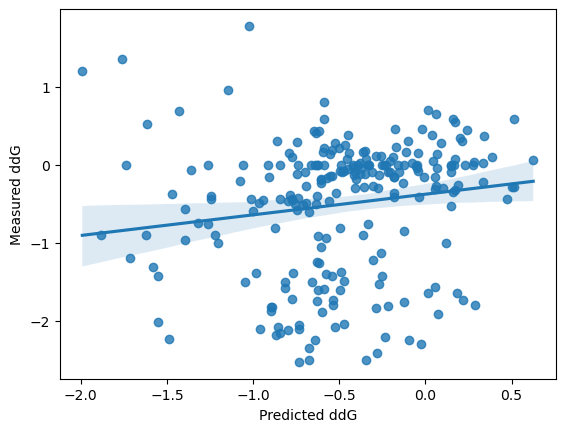

In [310]:
preds =[]
all_y = []
# save all predictions
for batch in dataloader_val:
    # adjust this to work with your model
    x = batch["sequence"][0]
    y = batch["labels"][0]
    y_hat = cnn_model(x)

    preds.append(y_hat.detach().numpy()[1])
    all_y.append(y.squeeze().detach().numpy()[1])
    print(y.squeeze().shape)
    
    print(y_hat.shape)

# concatenate and plot
preds = np.concatenate(preds)
all_y = np.concatenate(all_y)

sns.regplot(x=preds,y=all_y)
plt.xlabel("Predicted ddG")
plt.ylabel("Measured ddG")

# get RMSE, Pearson and Spearman correlation 
print("RMSE:", skmetrics.mean_squared_error(all_y, preds, squared = False))
print("Pearson r:", scipy.stats.pearsonr(preds, all_y))
print("Spearman r:", scipy.stats.spearmanr(preds, all_y))

In [311]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Reusing TensorBoard on port 6006 (pid 2554953), started 5:30:04 ago. (Use '!kill 2554953' to kill it.)

In [372]:
dataset_train.df["wt_seq"][2][0]
len(dataset_train.df["mutation_to"][2])

len(dataset_train.df["ddG_ML"][2])

618

In [373]:
dataset_train.df.loc["1E0L.pdb"]

Unnamed: 0      [200028, 200029, 200030, 200031, 200032, 20003...
name            [1E0L.pdb_G1Q, 1E0L.pdb_G1E, 1E0L.pdb_G1N, 1E0...
ddG_ML          [-0.134363487967859, -0.2192838778718004, -0.1...
mut_type        [G1Q, G1E, G1N, G1H, G1D, G1R, G1K, G1T, G1S, ...
aa_seq          [QATAVSEWTEYKTADGKTYYYNNRTLESTWEKPQELK, EATAVS...
wt_seq          [GATAVSEWTEYKTADGKTYYYNNRTLESTWEKPQELK, GATAVS...
mutation_pos    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
mutation_to     [13, 3, 11, 6, 2, 14, 8, 16, 15, 0, 10, 9, 17,...
Name: 1E0L.pdb, dtype: object

In [ ]:
print(len(dataset_train.df["mut_type"][2]))
dataset_train.df["mut_type"][2]

In [ ]:
print(len(dataset_train.df.loc["1E0L.pdb"]["ddG_ML"]))
print(getTensorFromProtein("1E0L.pdb", dataset_train.df["wt_seq"][0][0], dataset_train.df["mut_type"][0]).size)